In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import experimental, Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv
import numpy as np
from PIL import Image, ImageEnhance
import zipfile
import cv2
import matplotlib.pyplot as plt
import os

In [15]:
def extract_file_from_zip(zip_file_name, internal_file_path, destination_directory):
    with zipfile.ZipFile(zip_file_name, 'r') as zipf:
        zipf.extract(internal_file_path, destination_directory)

In [23]:
def removeBack(img, size_fill, enhance_val, buffer_size):
    img_img = Image.fromarray(img, mode="RGB")
    contr_img = ImageEnhance.Contrast(img_img).enhance(enhance_val)
    gray_img = pcv.rgb2gray_lab(rgb_img=np.array(contr_img), channel='a')
    thresh = pcv.threshold.triangle(
        gray_img=gray_img, object_type="dark", xstep=100)
    edge_ok = pcv.fill(bin_img=thresh, size=5000)
    mask = pcv.fill(bin_img=pcv.invert(gray_img=edge_ok), size=size_fill)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_buf = mask.copy()
    if (len(contours)):
        cv2.drawContours(mask_buf,
                         contours[np.argmax([len(c) for c in contours])],
                         -1, (0, 0, 0), buffer_size)
    if ([mask_buf[0, 0], mask_buf[0, -1],
         mask_buf[0, -1], mask_buf[-1, 0]] == [0, 0, 0, 0]):
        mask_buf[0:11, 0:11] = 255
        mask_buf[-11:, -11:] = 255
        mask_buf[0:11, -11:] = 255
        mask_buf[-11:, 0:11] = 255
    mask_buf[0:1, :] = 255
    mask_buf[-1:, :] = 255
    mask_buf[:, 0:1] = 255
    mask_buf[:, -1:] = 255
    mask_buf = pcv.fill(bin_img=mask_buf, size=size_fill)
    img_modified = np.ones_like(img) * 255
    img_modified[mask_buf == 0] = img[mask_buf == 0]
    return img_modified

In [17]:
model = load_model('model_param.keras')

In [19]:
class_names = np.genfromtxt('class_names.csv', delimiter=',', dtype=str)

In [20]:
class_names

array(['Apple_Black_rot', 'Apple_healthy', 'Apple_rust', 'Apple_scab',
       'Grape_Black_rot', 'Grape_Esca', 'Grape_healthy', 'Grape_spot'],
      dtype='<U15')

In [29]:
img = np.array(Image.open("../leaves/images/Apple_rust/image (28).JPG", "r"))

In [30]:
imgModified = removeBack(img, 5000, 1, 10)

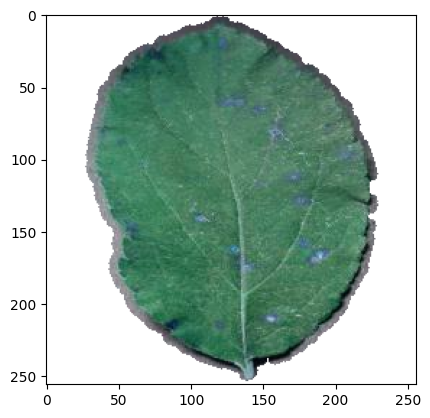

In [31]:
pcv.plot_image(imgModified)

In [32]:
modelWidth = model.layers[0].get_config()['batch_input_shape'][1]
modelHeigh = model.layers[0].get_config()['batch_input_shape'][2]

In [33]:
y_pred = model.predict(imgModified.reshape(1, modelWidth, modelHeigh, 3))
predictedClass = class_names[np.argmax(y_pred)]

1/1 [==============================] - 0s 15ms/step


In [34]:
predictedClass

'Apple_rust'

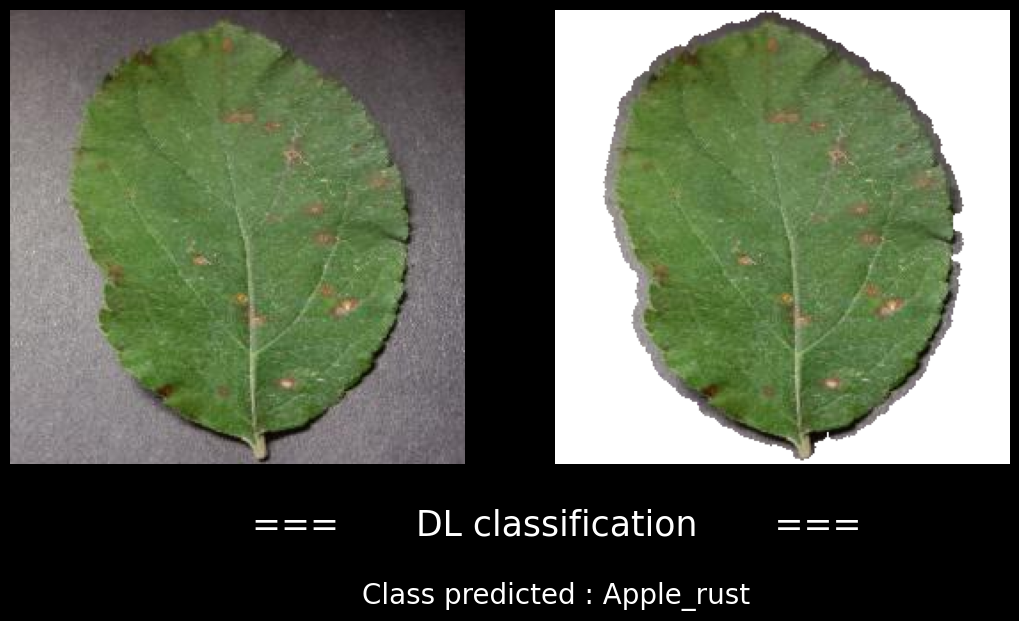

In [78]:
# Création de la figure et des sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Supprimer les axes pour les deux sous-graphiques
for axe in ax:
    axe.axis('off')

# Afficher les images sur le premier sous-graphique
ax[0].imshow(img)
ax[1].imshow(imgModified)

# Ajouter du texte en dessous des images
texte_partie1 = "===       DL classification       ==="
texte_partie2 = "Class predicted : " + predictedClass

ax[1].text(0, 290, texte_partie1, color='white', fontsize=25, ha='center', va='center', wrap=True)
ax[1].text(0, 330, texte_partie2, color='white', fontsize=20, ha='center', va='center', wrap=True)

# Réglages de l'apparence

fig.patch.set_facecolor('black')  # Définir la couleur de fond de la figure en noir
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1)

# Afficher le résultat
plt.show()


In [3]:
with zipfile.ZipFile("../Learning1.zip", 'w') as zipf:
        zipf.write("../class_names.csv")